In [16]:
from __future__ import print_function

import sys, os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow.keras
import pandas as pd
import numpy as np
import sklearn
import keras
import csv

import keras_uncertainty
from keras_uncertainty.utils import numpy_negative_log_likelihood, numpy_entropy
from keras_uncertainty.layers import DropConnectConv2D, DropConnectDense
from keras_uncertainty.models import MCDropoutClassifier
from keras_uncertainty.utils import numpy_regression_nll

import keras.backend as K
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
from keras.models import Model, Sequential
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt


In [17]:
def load_joint_space_csv_chunks(file_path):
    data_frame = pd.read_csv(file_path, skiprows=1, header=None)
    del data_frame[18]
    #print(data_frame.head(10))
    return data_frame

def load_task_space_csv_chunks(file_path):
    return pd.read_csv(file_path, skiprows=1, header=None)


In [18]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

TRAIN_FOLDER = '/home/dfki.uni-bremen.de/bmanickavasakan/newdataset_rh5_leg/leg_5steps/'
TEST_FOLDER = '/home/dfki.uni-bremen.de/bmanickavasakan/newdataset_rh5_leg/leg_5steps/test_4steps'

X_TRAIN_FILE = os.path.join(TRAIN_FOLDER, 'leg_forwardkinematics_x.csv')
Q_TRAIN_FILE = os.path.join(TRAIN_FOLDER, 'leg_sysstate_q.csv')

X_TEST_FILE = os.path.join(TEST_FOLDER, 'leg_forwardkinematics_x.csv')
Q_TEST_FILE = os.path.join(TEST_FOLDER, 'leg_sysstate_q.csv')

x_train = load_task_space_csv_chunks(X_TRAIN_FILE)
q_train = load_joint_space_csv_chunks(Q_TRAIN_FILE)

x_test = load_task_space_csv_chunks(X_TEST_FILE)
q_test = load_joint_space_csv_chunks(Q_TEST_FILE)




In [19]:

x_train_df = pd.DataFrame(x_train)
q_train_df = pd.DataFrame(q_train)
x_test_df = pd.DataFrame(x_test)
q_test_df = pd.DataFrame(q_test)


from sklearn.ensemble import IsolationForest


clf = IsolationForest(n_estimators=100, max_samples='auto', max_features=1, bootstrap=False, n_jobs= -1, random_state=42, verbose=0)
clf.fit(q_train_df)

pred = clf.predict(q_train_df)
q_train_df['anamoly'] = pred
print(q_train_df['anamoly'].value_counts())

InDistribution_Q_Train = q_train_df[q_train_df['anamoly'] == 1]
OutDistribution_Q_Train =   q_train_df[q_train_df['anamoly'] == -1]
InDistribution_X_Train =    x_train_df[q_train_df['anamoly'] == 1]
OutDistribution_X_Train =   x_train_df[q_train_df['anamoly'] == -1]

clf_test = IsolationForest(n_estimators=100, max_samples='auto', max_features=1, bootstrap=False, n_jobs= -1, random_state=42, verbose=0)
clf_test.fit(q_test_df)
pred_test = clf.predict(q_test_df)
q_test_df['anamoly'] = pred_test

InDistribution_Q_Test = q_test_df[q_test_df['anamoly'] == 1]
OutDistribution_Q_Test =q_test_df[q_test_df['anamoly'] == -1]
InDistribution_X_Test = x_test_df[q_test_df['anamoly'] == 1]
OutDistribution_X_Test =x_test_df[q_test_df['anamoly'] == -1]

x_train_1 = InDistribution_X_Train
q_train_1 = InDistribution_Q_Train.drop(['anamoly'], axis=1)
x_test_1 = InDistribution_X_Test
q_test_1 = InDistribution_Q_Test.drop(['anamoly'], axis=1)

OOD_x_train = OutDistribution_X_Train
OOD_q_train = OutDistribution_Q_Train.drop(['anamoly'], axis=1)
OOD_x_test = OutDistribution_X_Test
OOD_q_test = OutDistribution_Q_Test.drop(['anamoly'], axis=1)

q_test = q_test.drop(['anamoly'], axis=1)




/home/dfki.uni-bremen.de/bmanickavasakan/.local/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/dfki.uni-bremen.de/bmanickavasakan/.local/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/dfki.uni-bremen.de/bmanickavasakan/.local/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


 1    14062
-1     1563
Name: anamoly, dtype: int64


/home/dfki.uni-bremen.de/bmanickavasakan/.local/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/dfki.uni-bremen.de/bmanickavasakan/.local/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/dfki.uni-bremen.de/bmanickavasakan/.local/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


In [20]:

x_scaler = MinMaxScaler()
q_scaler = MinMaxScaler()

#In order training set
x_train_1 = x_scaler.fit_transform(x_train_1)
q_train_1 = q_scaler.fit_transform(q_train_1)

#complete test set
x_test = x_scaler.transform(x_test)
q_test = q_scaler.transform(q_test)

#split testing data
IOD_x_test = x_scaler.transform(x_test_1)
IOD_q_test = q_scaler.transform(q_test_1)

OOD_x_test = x_scaler.transform(OOD_x_test)
OOD_q_test = q_scaler.transform(OOD_q_test)

In [21]:
def model_builder(input_shape, output_shape):
    def build_model(depth, width, reduction_factor):
        model = Sequential()
        

        for i in range(depth):
            num_neurons = max(int(width * (reduction_factor ** i)), 4)
            if i == 0:
                model.add(DropConnectDense(num_neurons, activation='relu', input_shape=(input_shape,), prob=0.5))
            else:
                model.add(DropConnectDense(num_neurons, activation='relu', prob=0.5))

            model.add(BatchNormalization())
            #num_neurons= num_neurons + 32
            Flatten()

        model.add(DropConnectDense(output_shape, activation='sigmoid', prob=0.1))
        model.compile(loss='mse', optimizer='adam', metrics=["mae"])

        return model
    return build_model


In [22]:
HYPERPARAMETERS = {'depth': 6, 'width': 64, 'reduction_factor':  0.9}
import tensorflow as tf
with tf.device('/cpu:0'):
    model = model_builder(9, 18)(**HYPERPARAMETERS)
    hist = model.fit(x_train_1, q_train_1, epochs = 100, batch_size = 128, verbose = 1, validation_data=(IOD_x_test, IOD_q_test))
    model.save("ik-rh5-leg-5steps_dropconnect_OOD.h5")

Train on 14062 samples, validate on 3790 samples
Epoch 1/100
14062/14062 [==============================] - 2s 137us/step - loss: 0.1392 - mae: 0.3055 - val_loss: 0.0990 - val_mae: 0.2685
Epoch 2/100
14062/14062 [==============================] - 1s 40us/step - loss: 0.1196 - mae: 0.2842 - val_loss: 0.0982 - val_mae: 0.2674
Epoch 3/100
14062/14062 [==============================] - 1s 36us/step - loss: 0.1068 - mae: 0.2692 - val_loss: 0.0956 - val_mae: 0.2639
Epoch 4/100
14062/14062 [==============================] - 1s 39us/step - loss: 0.0956 - mae: 0.2548 - val_loss: 0.0815 - val_mae: 0.2402
Epoch 5/100
14062/14062 [==============================] - 1s 40us/step - loss: 0.0869 - mae: 0.2419 - val_loss: 0.0743 - val_mae: 0.2239
Epoch 6/100
14062/14062 [==============================] - 1s 39us/step - loss: 0.0797 - mae: 0.2306 - val_loss: 0.0689 - val_mae: 0.2120
Epoch 7/100
14062/14062 [==============================] - 1s 41us/step - loss: 0.0750 - mae: 0.2224 - val_loss: 0.0650 - 

ValueError: x and y must have same first dimension, but have shapes (200,) and (100,)

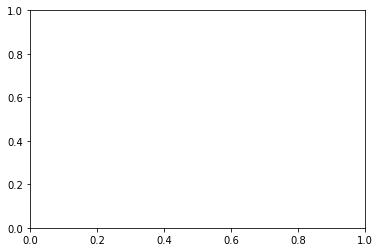

In [23]:
epoch  = list(range(0, 200, 1))
#print(epoch)
#print(hist.history['loss'])
plt.figure()
plt.plot( epoch, hist.history['loss'],     label = 'Loss')
plt.plot( epoch, hist.history['mae'],      label = 'MAE')
plt.plot( epoch, hist.history['val_loss'], label = 'val_loss')
plt.plot( epoch, hist.history['val_mae'],  label = 'val_mae')
plt.xlabel("Number of Epochs")
plt.ylabel("Error")
plt.legend(loc='upper right')


In [10]:
q_pred = model.predict(x_test, verbose=0)
q_unnorm = q_scaler.inverse_transform(q_test)
q_pred_unnorm = q_scaler.inverse_transform(q_pred)

global_mae = mean_absolute_error(q_test, q_pred)

print("Testing MAE: {:.5f}".format(global_mae))

# Compute MAE for each output independently.
for i in range(q_test.shape[1]):
    norm_mae_i = mean_absolute_error(q_test[:, i], q_pred[:, i])
    mae_i = mean_absolute_error(q_unnorm[:, i], q_pred_unnorm[:, i])
    print("Q feature {} has unnorm MAE: {:.4f} (Range {:.4f} to {:.4f}) normalized MAE: {:.4f}".format(i, mae_i, q_scaler.data_min_[i], q_scaler.data_max_[i], norm_mae_i))



Testing MAE: 0.10467
Q feature 0 has unnorm MAE: 0.1965 (Range -0.7330 to 0.4398) normalized MAE: 0.1675
Q feature 1 has unnorm MAE: 0.2385 (Range -0.3840 to 0.5792) normalized MAE: 0.2476
Q feature 2 has unnorm MAE: 0.0767 (Range -0.8200 to -0.0680) normalized MAE: 0.1020
Q feature 3 has unnorm MAE: 0.0764 (Range -0.8381 to -0.0792) normalized MAE: 0.1007
Q feature 4 has unnorm MAE: 0.0085 (Range 0.0070 to 0.0907) normalized MAE: 0.1020
Q feature 5 has unnorm MAE: 0.0440 (Range 0.0000 to 1.0000) normalized MAE: 0.0440
Q feature 6 has unnorm MAE: 0.0053 (Range -0.0822 to 0.0000) normalized MAE: 0.0643
Q feature 7 has unnorm MAE: 0.0033 (Range 0.0000 to 0.0782) normalized MAE: 0.0420
Q feature 8 has unnorm MAE: 0.1689 (Range -0.7850 to 0.4710) normalized MAE: 0.1345
Q feature 9 has unnorm MAE: 0.1000 (Range -0.7850 to 0.4710) normalized MAE: 0.0796
Q feature 10 has unnorm MAE: 0.1725 (Range -0.5905 to 0.8678) normalized MAE: 0.1183
Q feature 11 has unnorm MAE: 0.1818 (Range -0.5744 to 0

In [11]:
from keras.layers import Dense, Dropout
from tensorflow.keras.models import load_model
from keras_uncertainty.models import MCDropoutRegressor
from sklearn.preprocessing import MinMaxScaler

def test_mcdropconnect_regressor(x_test_values, q_test_values, model, data_scaler):   
    mc_model = MCDropoutRegressor(model)
    inp = x_test_values  
    
    mean, std = mc_model.predict(inp, num_samples = 10)
    
    q_pred_unnormalised = data_scaler.inverse_transform(mean)
    
    #q_sd_unnromalised = data_scaler.inverse_transform(std)
    
    global_mae = mean_absolute_error(q_test_values, mean)

    print("Testing MAE: {:.5f}".format(global_mae))

    return q_pred_unnormalised, std

mean_1, std_1 = test_mcdropconnect_regressor(x_test, q_test, model, q_scaler)

q_test_unorm = q_scaler.inverse_transform(q_test)

print("NLL: {:.5f}".format(numpy_regression_nll(q_test_unorm, mean_1, std_1**2)))


Testing MAE: 0.28742
NLL: 6.67680


In [12]:
mean_test_IOD, sd_test_IOD = test_mcdropconnect_regressor(IOD_x_test, IOD_q_test, model, q_scaler)
q_test_unorm = q_scaler.inverse_transform(IOD_q_test)
print("NLL: {:.5f}".format(numpy_regression_nll(q_test_unorm, mean_test_IOD, sd_test_IOD**2)))

Testing MAE: 0.25237
NLL: 6.06231


In [13]:
mean_test_OOD, sd_test_OOD = test_mcdropconnect_regressor(OOD_x_test, OOD_q_test, model, q_scaler)
q_test_unorm = q_scaler.inverse_transform(OOD_q_test)
print("NLL: {:.5f}".format(numpy_regression_nll(q_test_unorm, mean_test_OOD, sd_test_OOD**2)))

Testing MAE: 0.35367
NLL: 6.85776


In [33]:
col_no = 2

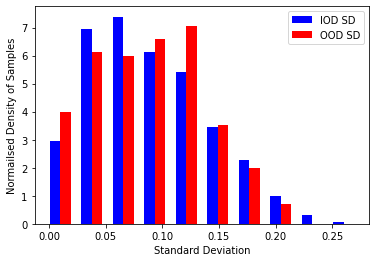

In [34]:
sd_test_IOD_df = pd.DataFrame(sd_test_IOD)
sd_test_OOD_df = pd.DataFrame(sd_test_OOD)
new_scores = np.concatenate([sd_test_IOD_df[col_no], sd_test_OOD_df[col_no]], axis=0)
minmaxscaler = MinMaxScaler()
new_scores_scaled = minmaxscaler.fit_transform(new_scores.reshape(-1, 1))

new_labels = np.concatenate([np.zeros_like(sd_test_IOD_df[col_no]), np.ones_like(sd_test_OOD_df[col_no])], axis=0)
histogram_df = pd.DataFrame(new_scores_scaled, new_labels)

import matplotlib.pyplot as plt
fig, ax = plt.subplots()

a_heights, a_bins = np.histogram(sd_test_IOD_df[col_no].values.reshape(-1, 1), density=True)
b_heights, b_bins = np.histogram(sd_test_OOD_df[col_no].values.reshape(-1, 1), bins=a_bins, density=True)

width = (a_bins[1] - a_bins[0])/3

ax.bar(a_bins[:-1], a_heights, width = width, facecolor='blue',label="IOD SD")
ax.bar(b_bins[:-1]+width, b_heights, width = width, facecolor='red', label="OOD SD")
ax.legend()
ax.set_xlabel("Standard Deviation")
ax.set_ylabel("Normailsed Density of Samples")
fig.savefig("density_vs_sd_dropconnect_iso_split_col_2.pdf")

0.5018185110455792


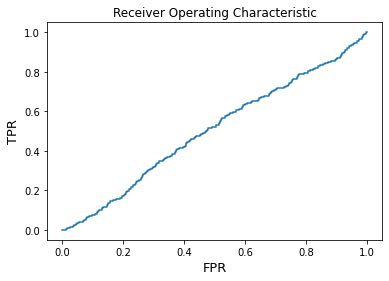

In [35]:
from sklearn.metrics import roc_curve, roc_auc_score

norm_scores = new_scores - min(new_scores) / (max(new_scores) - min(new_scores))

auc = roc_auc_score(new_labels, new_scores)
fpr, tpr, threshs = roc_curve(new_labels, norm_scores, drop_intermediate=True)
print(auc)
plt.xlabel('FPR', fontsize=13)
plt.ylabel('TPR', fontsize=13)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr)
plt.savefig("auc_dropconnect_iso_split_col_2.pdf")
plt.show()
